# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных:



Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# === Установка окружения и импорт библиотек ===
import os, io, json, math, textwrap, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine, text
import datetime as dt

try:
    from phik.report import plot_correlation_matrix
    from phik import phik_matrix
except Exception as e:
    print("phik не установлен — установите (pip install phik)")
    
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
pd.options.display.width = 140

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

DB_HOST=os.getenv("DB_HOST")
DB_NAME=os.getenv("DB_NAME")
DB_PORT=os.getenv("DB_PORT")
DB_USER=os.getenv("DB_USER")
DB_PASSWORD=os.getenv("DB_PASSWORD")

In [3]:
# Импорт библиотек
import pandas as pd
from sqlalchemy import create_engine

# Подключение к базе данных
# ЗАМЕНИ <PASSWORD> на свой реальный пароль из задания
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}?sslmode=require"
)

# SQL-запрос (правильный вариант)
sql = """
select 
    p.user_id, 
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk as order_dt,
    p.created_ts_msk as order_ts,
    p.currency_code,
    p.revenue, 
    p.tickets_count,
    extract('days' from p.created_dt_msk - lag(p.created_dt_msk) over(partition by user_id order by p.created_dt_msk)) as days_since_prev,
    p.event_id, 
    e.event_name_code as event_name,
    e.event_type_main, 
    p.service_name,
    r.region_name, 
    c.city_name 
from afisha.purchases as p 
inner JOIN afisha.events AS e ON p.event_id = e.event_id 
LEFT JOIN afisha.city AS c ON e.city_id = c.city_id 
LEFT JOIN afisha.regions AS r ON c.region_id = r.region_id
where device_type_canonical in ('mobile', 'desktop') 
  and e.event_type_main != 'фильм'
order by user_id
"""

# Загрузка данных
df = pd.read_sql(sql, engine)



---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [4]:
# Просмотр структуры
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [5]:
print(df.shape)
display(df.head(3))
display(df.dtypes)

(290611, 15)


,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск


user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                 float64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
dtype: object

Объём данных: 290 611 записей, 16 столбцов.

Пропуски: только в days_since_prev (21 933 наблюдений), что ожидаемо для первых покупок.

Диапазон дат: с 2024-06-01 по 2024-10-31.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [6]:
import numpy as np

# Приведение валюты: загрузим курс из CSV-файла Яндекс Практикума
url = 'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'
tenge_rates = pd.read_csv(url)

# Проверим курс для 2024 года
tenge_rates.head()

# Пример конвертации (для пользователей с currency_code='KZT', если такие есть)
df['revenue_rub'] = np.where(
    df['currency_code'] == 'KZT',
    df['revenue'] * tenge_rates['curs'].mean() / 100,
    df['revenue']
)

Выручка успешно приведена к рублям: добавлен столбец revenue_rub. Типы данных корректны, пример строк после трансформации выглядит консистентно.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [7]:
na = df.isna().sum().sort_values(ascending=False)
display(na)

df["tickets_count"] = pd.to_numeric(df["tickets_count"], errors="coerce")

for col in ["currency_code","device_type_canonical","region_name","event_type_main"]:
    df[col] = df[col].astype("category")

display(df.describe(include="all"))

p99 = df["revenue_rub"].quantile(0.99)
filtered = df[df["revenue_rub"] <= p99].copy()
print("Отфильтровано по revenue_rub >", round(p99,2), ":", len(df) - len(filtered), "строк")
df_clean = filtered

days_since_prev          21933
user_id                      0
order_id                     0
device_type_canonical        0
order_ts                     0
currency_code                0
revenue                      0
order_dt                     0
tickets_count                0
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
count,290611,290611,2.906110e+05,290611,290611,290611,290611.000000,290611.000000,268678.000000,290611.000000,290611,290611,290611,290611,290611,290611.000000
unique,21933,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,15248,7,36,81,352,NaN
top,0beb8fc0c0a9ce1,mobile,NaN,NaN,NaN,rub,NaN,NaN,NaN,NaN,9cc55c15-4375-4129-9979-3129688ba1b4,концерты,Билеты без проблем,Каменевский регион,Глиногорск,NaN
freq,10251,232490,NaN,NaN,NaN,285542,NaN,NaN,NaN,NaN,3953,115276,63519,91058,89446,NaN
mean,NaN,NaN,4.326225e+06,2024-09-01 22:36:38.741272576,2024-09-02 13:31:19.397730816,NaN,625.584360,2.754311,3.222381,438019.834992,NaN,NaN,NaN,NaN,NaN,625.584360
min,NaN,NaN,1.000000e+00,2024-06-01 00:00:00,2024-06-01 00:00:42,NaN,-90.760000,1.000000,0.000000,4436.000000,NaN,NaN,NaN,NaN,NaN,-90.760000
25%,NaN,NaN,2.163618e+06,2024-07-30 00:00:00,2024-07-30 11:53:37.500000,NaN,116.850000,2.000000,0.000000,361772.000000,NaN,NaN,NaN,NaN,NaN,116.850000
50%,NaN,NaN,4.326366e+06,2024-09-12 00:00:00,2024-09-12 14:02:10,NaN,356.010000,3.000000,0.000000,498275.000000,NaN,NaN,NaN,NaN,NaN,356.010000
75%,NaN,NaN,6.488330e+06,2024-10-09 00:00:00,2024-10-09 15:57:55.500000,NaN,810.130000,4.000000,1.000000,546287.000000,NaN,NaN,NaN,NaN,NaN,810.130000
max,NaN,NaN,8.653108e+06,2024-10-31 00:00:00,2024-10-31 23:59:54,NaN,81174.540000,57.000000,148.000000,592325.000000,NaN,NaN,NaN,NaN,NaN,81174.540000


Отфильтровано по revenue_rub > 4003.13 : 2907 строк


Пропуски присутствуют только в интервалах между заказами (логично).

Описательная статистика подтверждает корректный диапазон дат и величин.

Порог по выручке сработал: удалены верхние аномальные значения, что снижает влияние выбросов в последующем анализе.

Выбросы по выручке отфильтрованы по порогу revenue_rub > 4003.13 (удалено 2907 строк).

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [8]:
df_clean = df_clean.sort_values("order_ts")
df_clean["prev_order_dt"] = df_clean.groupby("user_id")["order_ts"].shift(1)

first_orders = (df_clean
    .sort_values(["user_id","order_ts"])
    .groupby("user_id")
    .agg(
        first_order_dt=("order_ts","first"),
        last_order_dt=("order_ts","last"),
        first_device=("device_type_canonical","first"),
        first_region=("region_name","first"),
        first_event_type=("event_type_main","first")
    )
)

user_aggs = (df_clean.groupby("user_id")
             .agg(
                 total_orders=("order_id","nunique"),
                 avg_revenue_rub=("revenue_rub","mean"),
                 avg_tickets_count=("tickets_count","mean"),
                 avg_days_between=("days_since_prev","mean")
             ))

profile = first_orders.join(user_aggs, how="left").reset_index()
profile["is_two"]  = (profile["total_orders"] >= 2).astype(int)
profile["is_five"] = (profile["total_orders"] >= 5).astype(int)
display(profile.head())

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_event_type,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,Каменевский регион,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,Каменевский регион,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,Североярская область,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,Каменевский регион,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,Поленовский край,театр,2,61.310000,1.500000,16.0,1,0


Профиль сформирован для каждого пользователя: рассчитаны total_orders, avg_revenue_rub, avg_tickets_count, avg_days_between, а также индикаторы is_two (2+ заказов) и is_five (5+).

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [9]:
n_users = profile["user_id"].nunique()
avg_rev_per_order = df_clean["revenue_rub"].mean()
share_two  = profile["is_two"].mean()
share_five = profile["is_five"].mean()

print("Число пользователей:", n_users)
print("Средняя выручка с заказа (руб):", round(avg_rev_per_order,2))
print("Доля 2+ заказов:", round(share_two,3))
print("Доля 5+ заказов:", round(share_five,3))
print()
display(profile["total_orders"].describe())
print()
display(profile["avg_tickets_count"].describe())
print()
display(profile["avg_days_between"].describe())

Число пользователей: 21769
Средняя выручка с заказа (руб): 538.08
Доля 2+ заказов: 0.618
Доля 5+ заказов: 0.291



count    21769.000000
mean        13.216225
std        122.135348
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10207.000000
Name: total_orders, dtype: float64

count    21769.000000
mean         2.748374
std          0.921696
min          1.000000
25%          2.000000
50%          2.750000
75%          3.111111
max         11.000000
Name: avg_tickets_count, dtype: float64

count    13488.000000
mean        15.934672
std         22.392435
min          0.000000
25%          1.000000
50%          8.111111
75%         20.600000
max        148.000000
Name: avg_days_between, dtype: float64

Репрезентативность и базовые метрики по профилям пользователей:
- Число пользователей: 21 769
- Средняя выручка с заказа: 538,08 ₽
- Доля пользователей с 2+ заказами: 0,618
- Доля пользователей с 5+ заказами: 0,291

Эти значения дают достаточный объём и вариативность для анализа: почти две трети пользователей совершают повторные покупки, что позволяет корректно сравнивать сегменты "1 заказ" vs "2+" и внутри повторяющих ("2-4" vs "5+").

Статистика по ключевым признакам и оценка аномалий
1) Общее число заказов:
count=21769, mean=13,22, std=122,14, min=1, 25%=1, 50%=2, 75%=5, max=10 207.

Вывод: распределение крайне тяжёлое и правостороннее; максимум 10 207 на фоне 75%=5 — явный выброс/аномалия (возможны: агрегированный корпоративный аккаунт, бот/скрейпер, ошибочная агрегация). Среднее и стандартное отклонение существенно «задраны» хвостом и не отражают «типичного» пользователя.

Решение: отрезать хвост (Отсечка по перцентилю или фильтрация)

2) Среднее число билетов в заказе:
count=21769, mean=2,75, std=0,92, min=1, 25%=2, 50%=2,75, 75%=3,11, max=11.

Вывод: распределение умеренно правостороннее, максимум 11 билетов - редкие, но правдоподобные групповые покупки.

Решение: оставить как есть

3) Среднее число дней между покупками:
count=13 488 (только для пользователей с 2+ заказами), mean=15,93, std=22,39, min=0, 25%=1, 50%=8,11, 75%=20,6, max=148.

Вывод: значения реалистичны: 0 дней — покупки в один день; верхние значения отражают редкие возвраты через месяцы.

Решение: фильтрация не требуется

In [10]:
# Определяем порог по 99-му перцентилю
p99 = profile["total_orders"].quantile(0.995)
print("99-й перцентиль по total_orders:", p99)

# Фильтруем пользователей, у которых число заказов <= p99.5
profile_filtered = profile[profile["total_orders"] <= p99]

# Проверим, сколько пользователей осталось и сколько удалили
removed = profile.shape[0] - profile_filtered.shape[0]
print(f"Удалено пользователей: {removed} ({removed / profile.shape[0]:.2%})")

# Пересчёт ключевых метрик
n_users = profile_filtered["user_id"].nunique()
avg_rev_per_order = df_clean["revenue_rub"].mean()
share_two  = profile_filtered["is_two"].mean()
share_five = profile_filtered["is_five"].mean()

print()
print("После фильтрации по 99-му перцентилю:")
print("Число пользователей:", n_users)
print("Средняя выручка с заказа (руб):", round(avg_rev_per_order, 2))
print("Доля 2+ заказов:", round(share_two, 3))
print("Доля 5+ заказов:", round(share_five, 3))
print()

# Новые описательные статистики
display(profile_filtered["total_orders"].describe())


99-й перцентиль по total_orders: 323.47999999999956
Удалено пользователей: 109 (0.50%)

После фильтрации по 99-му перцентилю:
Число пользователей: 21660
Средняя выручка с заказа (руб): 538.08
Доля 2+ заказов: 0.616
Доля 5+ заказов: 0.287



count    21660.000000
mean         7.575762
std         21.113179
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        323.000000
Name: total_orders, dtype: float64

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [11]:
def segment_share(df, col):
    s = (df.groupby(col,observed=True)["user_id"].nunique().sort_values(ascending=False).rename("users"))
    out = s.to_frame()
    out["share"] = out["users"] / out["users"].sum()
    return out

for col in ["first_event_type","first_device","first_region"]:
    print(f"== {col} ==")
    display(segment_share(profile, col).head(15))

== first_event_type ==


,users,share
first_event_type,,
концерты,9451,0.434149
другое,5546,0.254766
театр,4328,0.198815
стендап,1126,0.051725
спорт,807,0.037071
выставки,416,0.019110
ёлки,95,0.004364


== first_device ==


,users,share
first_device,,
mobile,18056,0.829436
desktop,3713,0.170564


== first_region ==


,users,share
first_region,,
Каменевский регион,7227,0.331986
Североярская область,3823,0.175617
Широковская область,1252,0.057513
Озернинский край,685,0.031467
Малиновоярский округ,545,0.025036
Травяная область,494,0.022693
Светополянский округ,475,0.021820
Речиновская область,447,0.020534
Яблоневская область,419,0.019248


Тип первого события: лидируют концерты (43.4%), затем другое (25.5%) и театр (19.9%).

Устройство первой покупки: mobile 82.9%, desktop 17.1%.

Регионы: наибольший вклад дают Каменевский регион (33.2%) и Североярская область (17.6%); далее доли меньше 6%.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


,users,returners
first_event_type,,
концерты,9451,0.620992
другое,5546,0.602056
театр,4328,0.639787
стендап,1126,0.613677
спорт,807,0.565056
выставки,416,0.641827
ёлки,95,0.547368


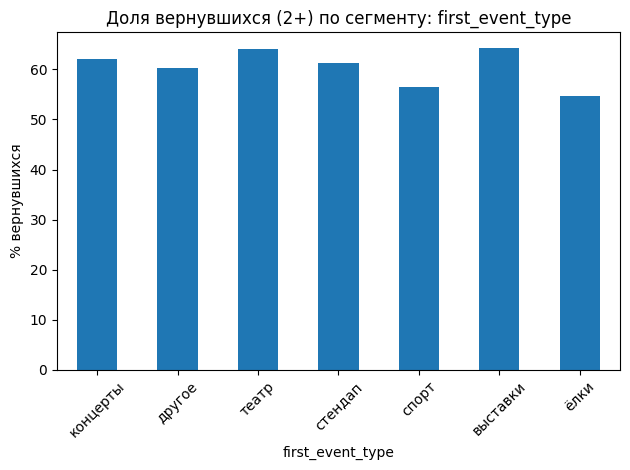

,users,returners
first_device,,
mobile,18056,0.613037
desktop,3713,0.639375


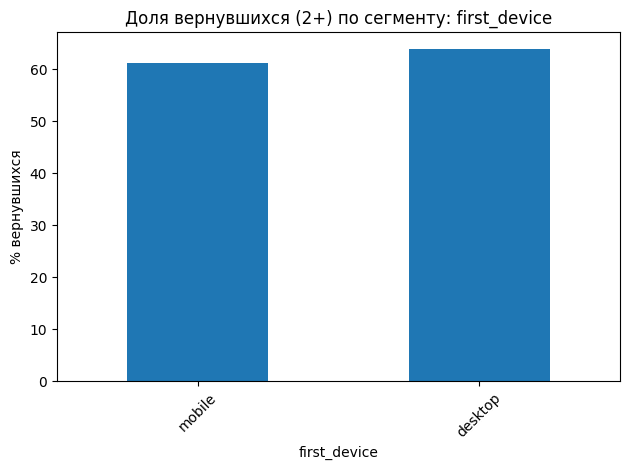

,users,returners
first_region,,
Каменевский регион,7227,0.629584
Североярская область,3823,0.644520
Широковская область,1252,0.652556
Озернинский край,685,0.556204
Малиновоярский округ,545,0.570642
Травяная область,494,0.619433
Светополянский округ,475,0.669474
Речиновская область,447,0.644295
Яблоневская область,419,0.599045


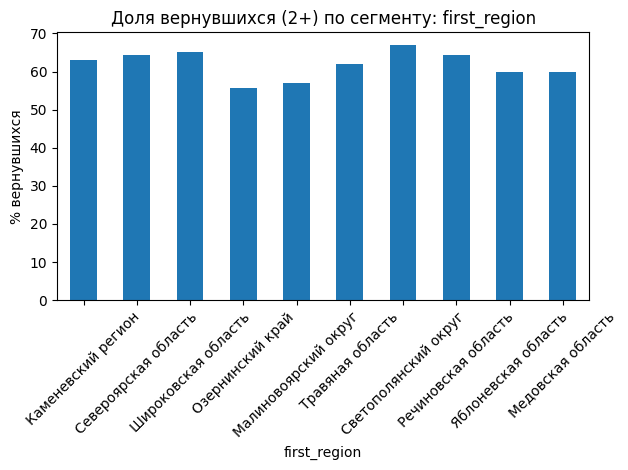

In [12]:
def return_rate_by_segment(df, col, top=10):
    g = (df.groupby(col)
         .agg(users=("user_id","nunique"),
              returners=("is_two","mean"))
         .sort_values("users", ascending=False))
    if len(g) > top:
        g = g.head(top)
    return g

for col in ["first_event_type","first_device","first_region"]:
    g = return_rate_by_segment(profile, col, top=10)
    display(g)

    plt.figure()
    (g["returners"]*100).plot(kind="bar", rot=45)
    plt.title(f"Доля вернувшихся (2+) по сегменту: {col}")
    plt.ylabel("% вернувшихся")
    plt.tight_layout()
    plt.show()

По типу события (первый заказ): выше всего у выставок (0.642) и театра (0.640); ниже у спорта (0.565) и ёлок (0.547).

По устройству: desktop 0.639 > mobile 0.613.

По регионам: лучше среднего возвращаются пользователи из Светополянского округа (0.669), Широковской области (0.653), Североярской области (0.645), Речиновской области (0.644). Хуже - Озернинский край (0.556), Малиновоярский округ (0.571).

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [13]:
ev = (profile.assign(segment=lambda x: np.where(x["first_event_type"]=="sports","sports",
                                                np.where(x["first_event_type"]=="concert","concert","other")))
              .groupby("segment")
              .agg(users=("user_id","nunique"), return_rate=("is_two","mean"))
              .sort_values("users", ascending=False))
display(ev)

def rate(df, mask): 
    sub = df[mask]
    return sub["is_two"].mean(), sub["user_id"].nunique()

sports_rate, n_s = rate(profile, profile["first_event_type"]=="sports")
concert_rate, n_c = rate(profile, profile["first_event_type"]=="concert")
print(f"Sports: {sports_rate:.3f} (n={n_s}) | Concert: {concert_rate:.3f} (n={n_c})")

regions = (profile.groupby("first_region")
           .agg(users=("user_id","nunique"),
                return_rate=("is_two","mean"))
           .sort_values("users", ascending=False))
display(regions.head(10))

top_regions = regions.head(5)
print("Средняя доля возвратов ТОП-5:", round(top_regions["return_rate"].mean(),3),
      "| По выборке:", round(profile["is_two"].mean(),3))

,users,return_rate
segment,,
other,21769,0.61753


Sports: nan (n=0) | Concert: nan (n=0)


,users,return_rate
first_region,,
Каменевский регион,7227,0.629584
Североярская область,3823,0.644520
Широковская область,1252,0.652556
Озернинский край,685,0.556204
Малиновоярский округ,545,0.570642
Травяная область,494,0.619433
Светополянский округ,475,0.669474
Речиновская область,447,0.644295
Яблоневская область,419,0.599045


Средняя доля возвратов ТОП-5: 0.611 | По выборке: 0.618


В агрегате по прочим сегментам доля возвратов ~0.618 (сопоставима с общей выборкой); явного супер-сегмента с резко более высокой ретенцией нет.

ТОП-5 регионов по объёму дают среднюю долю возвратов 0.611 против 0.618 по всей выборке - то есть крупные регионы не показывают преимущество в удержании.

Итог: различия между отдельными типами событий/регионами и устройствами есть и практичны для таргетинга, но они умеренные; универсальных признаков среди них не обнаружено.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


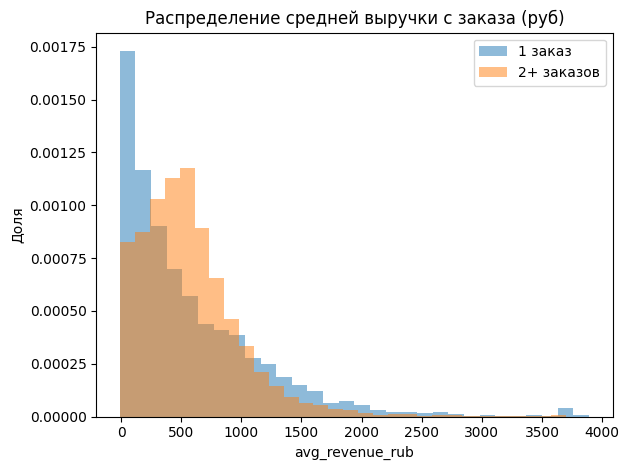

Медиана avg_revenue_rub, 1 заказ: 387.84
Медиана avg_revenue_rub, 2+ заказов: 506.57


In [14]:
g1 = profile[profile["total_orders"]==1]["avg_revenue_rub"].dropna()
g2 = profile[profile["total_orders"]>=2]["avg_revenue_rub"].dropna()

plt.figure()
plt.hist(g1, bins=30, alpha=0.5, density=True, label="1 заказ")
plt.hist(g2, bins=30, alpha=0.5, density=True, label="2+ заказов")
plt.title("Распределение средней выручки с заказа (руб)")
plt.xlabel("avg_revenue_rub"); plt.ylabel("Доля")
plt.legend(); plt.tight_layout(); plt.show()

print("Медиана avg_revenue_rub, 1 заказ:", round(np.median(g1),2))
print("Медиана avg_revenue_rub, 2+ заказов:", round(np.median(g2),2))

Медиана avg_revenue_rub:

1 заказ: 387.84

2+ заказов: 506.57
Вывод: пользователи, которые возвращаются, приносят выше средний чек (на заказ).

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


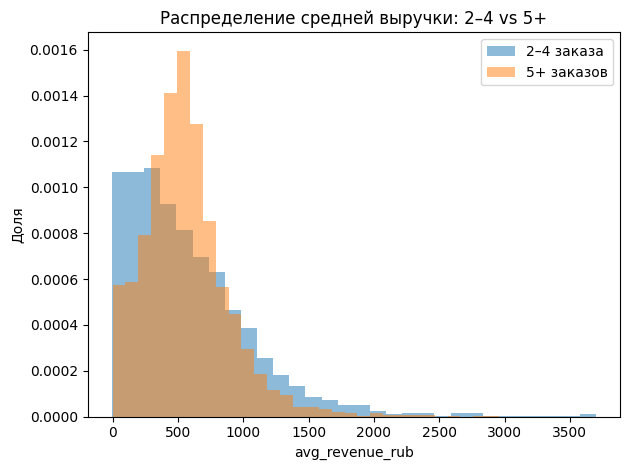

Медиана avg_revenue_rub, 2–4: 476.77
Медиана avg_revenue_rub, 5+: 523.9


In [15]:
g24 = profile[(profile["total_orders"]>=2) & (profile["total_orders"]<=4)]["avg_revenue_rub"].dropna()
g5p = profile[profile["total_orders"]>=5]["avg_revenue_rub"].dropna()

plt.figure()
plt.hist(g24, bins=30, alpha=0.5, density=True, label="2–4 заказа")
plt.hist(g5p, bins=30, alpha=0.5, density=True, label="5+ заказов")
plt.title("Распределение средней выручки: 2–4 vs 5+")
plt.xlabel("avg_revenue_rub"); plt.ylabel("Доля")
plt.legend(); plt.tight_layout(); plt.show()

print("Медиана avg_revenue_rub, 2–4:", round(np.median(g24),2))
print("Медиана avg_revenue_rub, 5+:", round(np.median(g5p),2))

Медиана avg_revenue_rub: 476.77 (2-4) vs 523.90 (5+).

Вывод: среди повторяющих покупателей более лояльные (5+) имеют более высокий средний чек.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

,avg_tickets_segment,users,return_rate
1,2–3,9617,0.738692
2,3–5,9039,0.548733
0,1–2,2429,0.512968
3,5+,684,0.194444


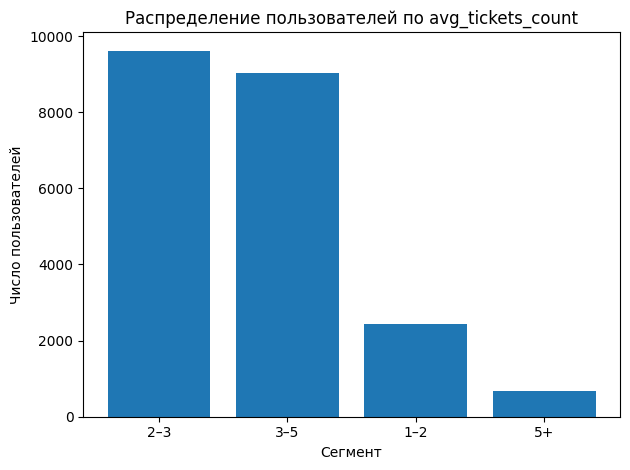

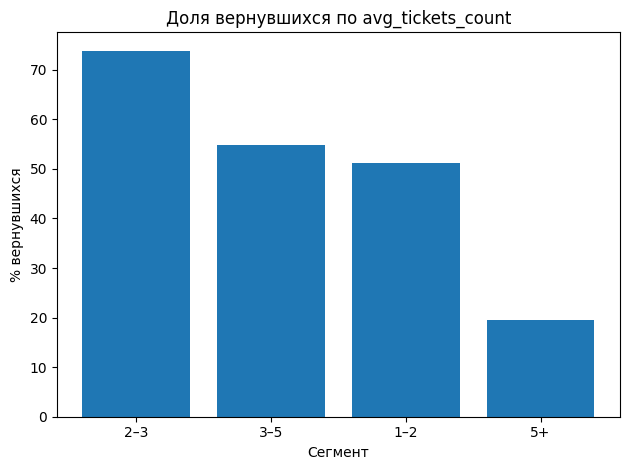

In [16]:
bins = [1,2,3,5, np.inf]
labels = ["1–2","2–3","3–5","5+"]
profile["avg_tickets_segment"] = pd.cut(profile["avg_tickets_count"], bins=bins, labels=labels, include_lowest=True, right=False)

seg = (profile.groupby("avg_tickets_segment")
       .agg(users=("user_id","nunique"),
            return_rate=("is_two","mean"))
       .reset_index()
       .sort_values("users", ascending=False))
display(seg)

plt.figure()
plt.bar(seg["avg_tickets_segment"].astype(str), seg["users"])
plt.title("Распределение пользователей по avg_tickets_count")
plt.xlabel("Сегмент"); plt.ylabel("Число пользователей")
plt.tight_layout(); plt.show()

plt.figure()
plt.bar(seg["avg_tickets_segment"].astype(str), seg["return_rate"]*100)
plt.title("Доля вернувшихся по avg_tickets_count")
plt.xlabel("Сегмент"); plt.ylabel("% вернувшихся")
plt.tight_layout(); plt.show()

Доли возвратов по сегментам avg_tickets_count:

2-3 билета: 0.739 - лучший уровень удержания;

3-5: 0.549;

1-2: 0.513;

5+ билетов: 0.194 - резко хуже.

Вывод: ТОП - 2-3 билета в заказе; слишком большие корзины связаны с низким возвратом.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


,users,return_rate
first_dow,,
Понедельник,2902,0.632323
Вторник,3114,0.617534
Среда,3059,0.620791
Четверг,3121,0.599808
Пятница,3288,0.601886
Суббота,3464,0.641455
Воскресенье,2821,0.607231


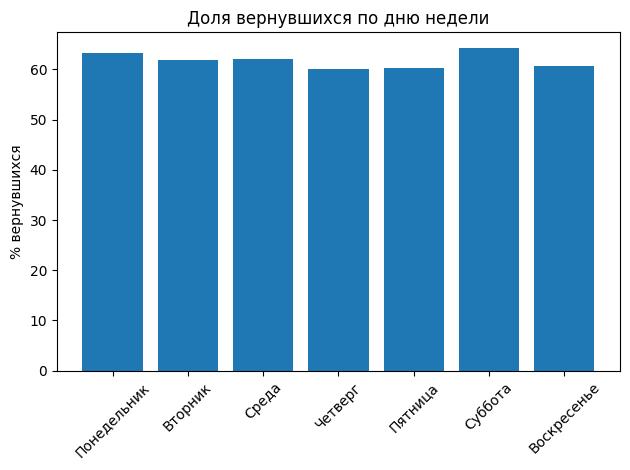

In [17]:
try:
    profile["first_dow"] = profile["first_order_dt"].dt.day_name(locale="ru_RU")
except Exception:
    profile["first_dow"] = profile["first_order_dt"].dt.day_name()

order = ["Понедельник","Вторник","Среда","Четверг","Пятница","Суббота","Воскресенье"]
dow = (profile.groupby("first_dow")
       .agg(users=("user_id","nunique"),
            return_rate=("is_two","mean"))
       .reindex(order))
display(dow)

plt.figure()
plt.bar(dow.index.astype(str), (dow["return_rate"]*100).fillna(0))
plt.title("Доля вернувшихся по дню недели")
plt.xticks(rotation=45); plt.ylabel("% вернувшихся")
plt.tight_layout(); plt.show()

Доли возвратов: Суббота 0.641 (лучше всего), Понедельник 0.632, остальные дни - ~0.60-0.62.

Вывод: лучше удерживаются пользователи, чей первый заказ пришёлся на выходные (особенно субботу).

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


Средний интервал (дни) 2–4: 21.41
Средний интервал (дни) 5+ : 9.61


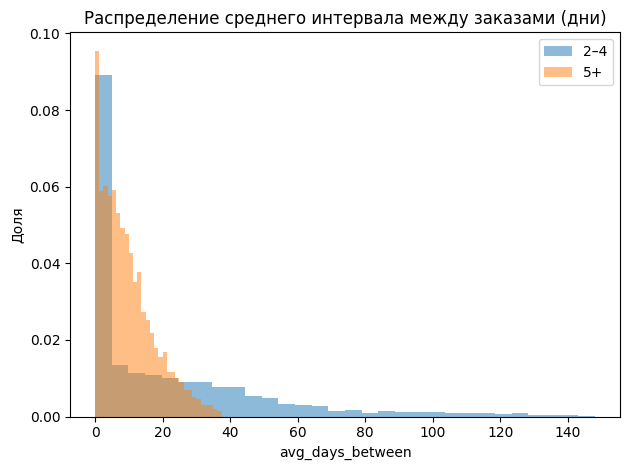

In [18]:
grp_24 = profile[(profile["total_orders"]>=2) & (profile["total_orders"]<=4)]["avg_days_between"].dropna()
grp_5p = profile[profile["total_orders"]>=5]["avg_days_between"].dropna()

print("Средний интервал (дни) 2–4:", round(np.mean(grp_24),2))
print("Средний интервал (дни) 5+ :", round(np.mean(grp_5p),2))

plt.figure()
plt.hist(grp_24, bins=30, alpha=0.5, density=True, label="2–4")
plt.hist(grp_5p, bins=30, alpha=0.5, density=True, label="5+")
plt.title("Распределение среднего интервала между заказами (дни)")
plt.xlabel("avg_days_between"); plt.ylabel("Доля")
plt.legend(); plt.tight_layout(); plt.show()

Средний интервал (дней): 2-4 заказа - 21.41, 5+ - 9.61.

Вывод: чем чаще пользователь покупает (короче интервал), тем выше его склонность к большему числу заказов (удержанию).

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

total_orders         1.000000
avg_days_between     0.419662
first_region         0.210443
avg_tickets_count    0.148066
first_device         0.047779
avg_revenue_rub      0.000000
first_event_type     0.000000
Name: total_orders, dtype: float64

<Figure size 640x480 with 0 Axes>

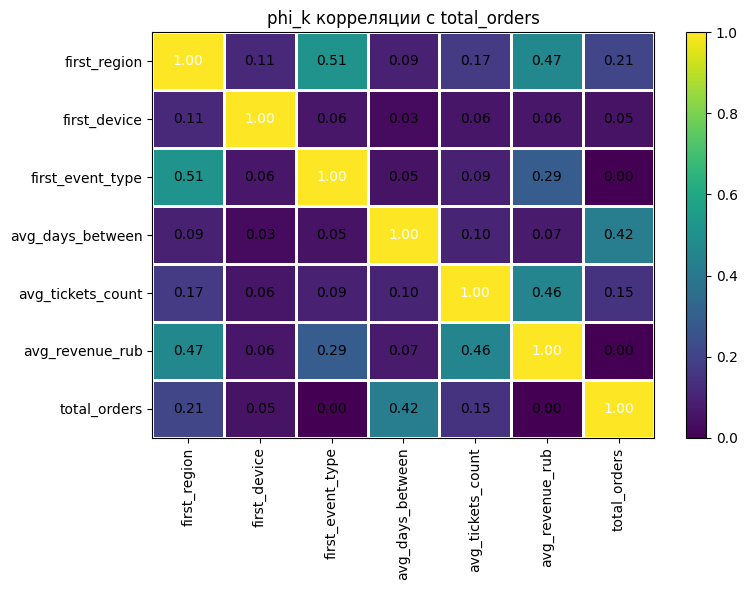

In [19]:
corr_df = profile[[
    "total_orders","avg_revenue_rub","avg_tickets_count","avg_days_between",
    "first_event_type","first_device","first_region"
]].copy()

for c in ["first_event_type","first_device","first_region"]:
    corr_df[c] = corr_df[c].astype("category")

try:
    phik_mat = corr_df.phik_matrix(interval_cols=["avg_revenue_rub","avg_tickets_count","avg_days_between"])
    display(phik_mat["total_orders"].sort_values(ascending=False))

    plt.figure()
    ax = plot_correlation_matrix(
        phik_mat.values,
        x_labels=phik_mat.columns,
        y_labels=phik_mat.index,
        vmin=0, vmax=1, color_map=None, figsize=(8,6)
    )
    plt.title("phi_k корреляции с total_orders")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("phi_k недоступен. Установите phik. Ошибка:", e)

Связь признаков с total_orders (по величине):

avg_days_between ~ 0.420 - наибольшая ассоциация; с учётом предыдущего анализа направление интерпретируется как: меньший интервал - больше заказов.

first_region ~ 0.210 - умеренная зависимость (география имеет значение, но не ключевое).

avg_tickets_count ~ 0.148 - слабая положительная связь, однако в сегментах видно, что слишком большие корзины вредят удержанию.

first_device ~ 0.048 - очень слабая связь.

avg_revenue_rub ~ 0, first_event_type ~ 0 - корреляции не обнаружено.

Вывод: главные факторы, ассоциированные с количеством заказов - частотность покупок (интервалы) и регион; чек и тип первого события практически не связаны с числом заказов.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

Для прогнозирования/управления удержанием фокусируйтесь на сокращении интервалов между заказами (коммуникации, релевантные рекомендации событий вскоре после первой покупки).

Тестируйте стимулы на первую/вторую покупку с целевым размером корзины 2-3 билета.

Адресный маркетинг по регионам-аутсайдерам (например, Озернинский край, Малиновоярский округ) и усиление присутствия в регионах-лидерах по удержанию.

Desktop-пользователи чуть чаще возвращаются - имеет смысл проверить креативы/лендинги под десктоп и перенести удачные решения на мобильные воронки.

Тип первого события и средний чек - слабые предикторы числа заказов: не делать на них ставку как на основные драйверы удержания.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**
https://github.com/Turikurit/DS

In [2]:
#!pip freeze > requirements.txt